# Multi-Unit Floor Plan Recognition (MUFPR)

This section refers to the paper on **Multi-Unit Floor Plan Recognition (MUFPR)**. You can find the paper [here](https://arxiv.org/pdf/2408.01526).

### Citation
If you're referencing this work, please use the following citation:

```bibtex
@inproceedings{aaf2018,
    author = {Ke, Tsung-Wei and Hwang, Jyh-Jing and Liu, Ziwei and Yu, Stella X.},
    title = {Adaptive Affinity Fields for Semantic Segmentation},
    booktitle = {European Conference on Computer Vision (ECCV)},
    month = {September},
    year = {2018}
}

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import numpy as np
import matplotlib.pyplot as plt
# from dataset import CamSegDataset
import torch
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
import torchvision.transforms as transforms
import torch.nn.functional as F
from PIL import Image
from numpy import linalg as LA
from torch import optim, nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
from torchvision import transforms, models
from tqdm import tqdm
import random
from datetime import datetime
import time
from torch.utils.tensorboard import SummaryWriter
import glob
import albumentations as A

In [2]:
DATA_DIR = './data/CamVid/'
EXPANDED_DATA_DIR = "./data/CamVidExpanded/"

In [3]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [4]:
expanded_x_train_dir = os.path.join(EXPANDED_DATA_DIR, 'train')
expanded_y_train_dir = os.path.join(EXPANDED_DATA_DIR, 'trainannot')

expanded_x_valid_dir = os.path.join(EXPANDED_DATA_DIR, 'val')
expanded_y_valid_dir = os.path.join(EXPANDED_DATA_DIR, 'valannot')

expanded_x_test_dir = os.path.join(EXPANDED_DATA_DIR, 'test')
expanded_y_test_dir = os.path.join(EXPANDED_DATA_DIR, 'testannot')

## Dataset

### Dataset Class

In [5]:
class CamSegDataset_Original(Dataset):
    """
    PyTorch CamSeg Dataset for loading and transforming images and masks for segmentation tasks.

    Args:
        images_dir (str): Path to the images folder.
        masks_dir (str): Path to the segmentation masks folder.
        classes (list): Class names to extract from segmentation mask.
        augmentation (albumentations.Compose): Data transformation pipeline (e.g., flip, scale).
        preprocessing (albumentations.Compose): Data preprocessing (e.g., normalization).
    """

    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']

    def __init__(self, images_dir, masks_dir, classes=None, augmentation=None, preprocessing=None):
        self.images_fps = sorted([os.path.join(images_dir, img) for img in os.listdir(images_dir)])
        self.masks_fps = sorted([os.path.join(masks_dir, img) for img in os.listdir(masks_dir)])
        # Convert class names to class indices
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        # Load image and mask
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        # Extract specific classes from mask
        masks = [(mask == v).astype('float32') for v in self.class_values]
        mask = np.stack(masks, axis=-1)

        # Apply augmentations
        if self.augmentation:
            augmented = self.augmentation(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']

        # Apply preprocessing
        if self.preprocessing:
            processed = self.preprocessing(image=image, mask=mask)
            image, mask = processed['image'], processed['mask']

        # Convert to torch tensors
        image = transforms.ToTensor()(image)
        mask = torch.tensor(mask).permute(2, 0, 1)  # Move channels to first dimension
        return image, mask

    def __len__(self):
        return len(self.images_fps)

In [44]:
class CamSegDataset(Dataset):
    """
    PyTorch CamSeg Dataset for loading and transforming images and masks for segmentation tasks.

    Args:
        images_dir (str): Path to the images folder.
        masks_dir (str): Path to the segmentation masks folder.
        classes (list): Class names to extract from segmentation mask.
        augmentation (albumentations.Compose): Data transformation pipeline (e.g., flip, scale).
        preprocessing (albumentations.Compose): Data preprocessing (e.g., normalization).
    """

    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']

    def __init__(self, images_dir, masks_dir, classes=None, augmentation=None, preprocessing=None):
        self.images_fps = sorted([os.path.join(images_dir, img) for img in os.listdir(images_dir)])
        self.masks_fps = sorted([os.path.join(masks_dir, img) for img in os.listdir(masks_dir)])
        # Convert class names to class indices
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        # Ensure 'unlabelled' is the first class in the list of class values
        if 'unlabelled' in classes:
            unlabelled_index = self.CLASSES.index('unlabelled')
            self.class_values.remove(unlabelled_index)
            self.class_values = [unlabelled_index] + self.class_values

        self.augmentation = augmentation
        self.preprocessing = preprocessing

        # Create a mapping from original class indices to new indices
        self.class_mapping = {self.CLASSES.index(cls): i for i, cls in enumerate(classes)}

    def __getitem__(self, i):
        # Load image and mask
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
    
        # Remap mask values to match new class indices
        remapped_mask = np.zeros_like(mask, dtype='float32')
        for original_class, new_class in self.class_mapping.items():
            remapped_mask[mask == original_class] = new_class
    
        # Extract specific classes from mask
        masks = [(remapped_mask == v).astype('float32') for v in range(len(self.class_values))]
        mask = np.stack(masks, axis=-1)
    
        # Debug: Print unique values in each mask channel to verify correct extraction
        for idx, class_name in enumerate(self.class_values):
            unique_values = np.unique(mask[:, :, idx])
            # print(f"Class '{self.CLASSES[class_name]}' (Channel {idx}): Unique values in mask - {unique_values}")
    
        # Apply augmentations
        if self.augmentation:
            augmented = self.augmentation(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']
    
        # Apply preprocessing
        if self.preprocessing:
            processed = self.preprocessing(image=image, mask=mask)
            image, mask = processed['image'], processed['mask']
    
        # Convert to torch tensors
        image = transforms.ToTensor()(image)
        mask = torch.tensor(mask).permute(2, 0, 1)  # Move channels to first dimension
        return image, mask

    def __len__(self):
        return len(self.images_fps)

### Dataloader and utility functions

In [45]:
def visualize(**images):
    """Plot images in one row with color for each class mask.
    Helper function for data visualization with debugging
    """
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())

        # Ensure the image has the correct format for imshow
        if isinstance(image, torch.Tensor):
            image = image.numpy()  # Convert tensor to numpy array if needed

        # Transpose if the image is in (channels, height, width) format
        if image.ndim == 3 and image.shape[0] == 3:
            image = np.transpose(image, (1, 2, 0))

        # Print shape for debugging
        print(f"{name} - shape: {image.shape}")
        # print(f"{name} - tensors: {image}")
        
        # Display with a color map for masks
        plt.imshow(image, cmap='gray' if image.ndim == 2 else None)
    plt.show()
    
def colorize_mask(mask, color):
    """Apply a color to a single-channel mask."""
    colored_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)  # Create a 3-channel image
    for c in range(3):  # Apply the color
        colored_mask[..., c] = mask * color[c]
    return colored_mask

# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

### Augmentation

In [8]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0, value=(0, 0, 0)),
        A.RandomCrop(height=320, width=320, always_apply=True),

        A.GaussNoise(p=0.2),
        A.Perspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.Sharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomBrightnessContrast(brightness_limit=0, contrast_limit=0.2, p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


# def get_validation_augmentation():
#     """Add paddings to make image shape divisible by 32"""
#     test_transform = [
#         A.PadIfNeeded(384, 480)
#     ]
#     return A.Compose(test_transform)

def get_preprocessing():
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0, value=(0, 0, 0)),
        A.RandomCrop(height=320, width=320, always_apply=True),
    ]
    return A.Compose(_transform)

## Model

### Stacks

In [9]:
class EncodeLayer(nn.Module):
    """
    A PyTorch module for an encoding layer that can perform either:
    (1) Max Pooling, (2) Average Pooling, or (3) Strided Convolution.

    This layer can be configured to use a specific activation function and 
    optional batch normalization.

    Args:
        channel (int): The number of input and output channels (filters).
        pool_size (int): The encoding factor, typically the kernel size for pooling.
        pool (str or bool): Pooling type - 
                            True or 'max' for Max Pooling,
                            'ave' for Average Pooling,
                            False for strided convolution + batch norm + activation.
        kernel_size (int or str): Size of convolution kernels. If 'auto', kernel size 
                                  will match the pool size (only used for strided conv).
        activation (str or None): Name of the activation function, e.g., 'ReLU'. Set to 
                                  None if no activation is desired.
        batch_norm (bool): True for batch normalization, False otherwise.

    Example Usage:
    --------------
        # Instantiate an EncodeLayer with max pooling
        encode_layer = EncodeLayer(channel=64, pool_size=2, pool='max', activation='ReLU', batch_norm=True)
        output = encode_layer(input_tensor)

        # Instantiate an EncodeLayer with strided convolution
        encode_layer = EncodeLayer(channel=64, pool_size=2, pool=False, activation='ReLU', batch_norm=True)
        output = encode_layer(input_tensor)

    """
    def __init__(self, channel, pool_size=2, pool='max', kernel_size='auto',
                 activation='ReLU', batch_norm=False):
        super(EncodeLayer, self).__init__()
        
        # Determine if we use pooling or strided convolution
        if pool not in [False, True, 'max', 'ave']:
            raise ValueError('Invalid pool keyword')
        
        # Set default pooling to 'max' if pool is True
        if pool is True:
            pool = 'max'
        
        self.layer = None
        self.activation = None
        
        # Max Pooling
        if pool == 'max':
            self.layer = nn.MaxPool2d(kernel_size=pool_size)
        
        # Average Pooling
        elif pool == 'ave':
            self.layer = nn.AvgPool2d(kernel_size=pool_size)
        
        # Strided Convolution
        else:
            # If kernel_size is 'auto', set it to pool_size
            if kernel_size == 'auto':
                kernel_size = pool_size
            
            # Define a strided convolution with optional batch normalization
            layers = [nn.Conv2d(channel, channel, kernel_size=kernel_size, 
                                stride=pool_size, padding=0, bias=self.bias_flag)]
            
            if batch_norm:
                layers.append(nn.GroupNorm(num_groups=16, num_channels=channel))
            
            # Create a Sequential module for the strided convolution and normalization
            self.layer = nn.Sequential(*layers)
        
        # Define the activation function
        if activation is not None:
            self.activation = getattr(nn, activation)()

    def forward(self, X):
        X = self.layer(X)
        if self.activation:
            X = self.activation(X)
        return X
    

class DecodeLayer(nn.Module):
    """
    A PyTorch module for a decoding layer that can perform either:
    (1) Upsampling with interpolation (nearest or bilinear), or
    (2) Transposed Convolution (ConvTranspose2d) with optional batch normalization and activation.

    Args:
        channel (int): The number of output channels (filters).
        pool_size (int): The decoding factor, typically the kernel size for upsampling or transposed convolution stride.
        unpool (str or bool): Upsampling method -
                              True or 'bilinear' for bilinear upsampling,
                              'nearest' for nearest neighbor upsampling,
                              False for ConvTranspose2d.
        kernel_size (int or str): Size of convolution kernels. If 'auto', kernel size will match the pool size (only used for transposed conv).
        activation (str or None): Name of the activation function, e.g., 'ReLU'. Set to None if no activation is desired.
        batch_norm (bool): True for batch normalization, False otherwise.

    Example Usage:
    --------------
        # Instantiate a DecodeLayer with bilinear upsampling
        decode_layer = DecodeLayer(channel=64, pool_size=2, unpool='bilinear', activation='ReLU', batch_norm=True)
        output = decode_layer(input_tensor)

        # Instantiate a DecodeLayer with transposed convolution
        decode_layer = DecodeLayer(channel=64, pool_size=2, unpool=False, activation='ReLU', batch_norm=True)
        output = decode_layer(input_tensor)

    """
    def __init__(self, in_channels, out_channels, pool_size=2, unpool='nearest', kernel_size=3, activation='ReLU', batch_norm=False):
        super(DecodeLayer, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        # Set up the upsampling method or transposed convolution
        if unpool not in [False, True, 'bilinear', 'nearest']:
            raise ValueError("Invalid unpool keyword: must be one of [True, False, 'bilinear', 'nearest']")
        
        # Configure upsampling
        if unpool in ['bilinear', 'nearest', True]:
            self.use_upsampling = True
            self.interpolation = 'bilinear' if unpool in [True, 'bilinear'] else 'nearest'
            self.upsample_layer = nn.Upsample(scale_factor=pool_size, mode=self.interpolation)
        else:
            # Configure transposed convolution
            self.use_upsampling = False
            if kernel_size == 'auto':
                kernel_size = pool_size
            
            # Define a transposed convolution with optional batch normalization
            layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=pool_size, padding='same')]
            if batch_norm:
                layers.append(nn.GroupNorm(num_groups=16, num_channels=out_channels))
            self.trans_conv_layer = nn.Sequential(*layers)

        # Define the activation function
        if activation is not None:
            self.activation = getattr(nn, activation)()
        else:
            self.activation = None

    def forward(self, X):
        """
        Forward pass through the decoding layer.

        Args:
            X (torch.Tensor): Input tensor of shape (batch_size, channels, height, width).

        Returns:
            torch.Tensor: Output tensor after applying upsampling or transposed convolution, 
                          optional batch normalization, and activation function.
        """
        # If upsampling, apply upsampling with specified interpolation
        # print ("decode layer expected in channels: ", self.in_channels)
        # print ("decode layer expected out channels: ", self.out_channels)
        
        # print ("decode layer forward pass input shape: ", X.shape)
        if self.use_upsampling:
            X = self.upsample_layer(X)
        else:
            # Apply transposed convolution
            X = self.trans_conv_layer(X)
        
        # Apply activation function if specified
        if self.activation:
            X = self.activation(X)
        # print ("decode layer forward pass output shape: ", X.shape)
        return X

In [10]:
class ConvStack(nn.Module):
    """
    A PyTorch module that creates a stack of convolutional layers, 
    each optionally followed by batch normalization and an activation function.
    
    Args:
        in_channels (int): Number of input channels to the convolutional layers.
        out_channels (int): Number of output channels from the convolutional layers.
        kernel_size (int or tuple, optional): Size of the convolutional kernel. Default is 3.
        stack_num (int, optional): Number of times to repeat the convolutional block. Default is 2.
        dilation_rate (int, optional): Dilation rate for dilated convolution. Default is 1.
        activation (str, optional): Name of the activation function to use (e.g., 'ReLU'). Default is 'ReLU'.
        batch_norm (bool, optional): Whether to include batch normalization layers. Default is False.
        square_conv (bool, optional): Whether to use square convolution kernels. Default is True.
        groups (int, optional): Number of groups for group normalization. Default is 16.
        use_bn (bool, optional): Use BatchNorm2d if True and out_channels > 16; otherwise, use GroupNorm. Default is False.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stack_num=2,
                 dilation_rate=1, activation='ReLU', batch_norm=False,
                 square_conv=True, enhance_skeleton=True, groups=16):

        super(ConvStack, self).__init__()

        # Initialize a list to hold the sequence of layers
        self.square_conv = square_conv
        self.enhance_skeleton = enhance_skeleton
        self.in_channels = in_channels
        self.out_channels = out_channels
        # Decide whether to include bias in convolutional layers
        self.batch_norm = batch_norm
        self.stack_num = stack_num
        self.groups = groups
        self.dilation_rate = dilation_rate

        # Instantiate module lists since they have to be applied independently of each other
        self.square_convs = nn.ModuleList()
        self.horiz_convs = nn.ModuleList()
        self.vert_convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        self.activations = nn.ModuleList()

        # Build the stack of convolutional blocks
        for i in range(stack_num):
            # Adjust in_channels for subsequent stacks
            conv_in_channels = in_channels if i == 0 else out_channels

            if square_conv:
                self.square_convs.append(
                    nn.Conv2d(
                        conv_in_channels, out_channels, kernel_size=kernel_size,
                        padding='same', dilation=dilation_rate, bias=not batch_norm
                    )
                )

            if enhance_skeleton:
                self.horiz_convs.append(
                    nn.Conv2d(
                        conv_in_channels, out_channels, kernel_size=(1, kernel_size),
                        padding='same', dilation=dilation_rate, bias=not batch_norm
                    )
                )
                self.vert_convs.append(
                    nn.Conv2d(
                        conv_in_channels, out_channels, kernel_size=(kernel_size, 1),
                        padding='same', dilation=dilation_rate, bias=not batch_norm
                    )
                )

            if batch_norm:
                self.bns.append(
                    nn.GroupNorm(num_groups=groups, num_channels=out_channels)
                )

            self.activations.append(getattr(nn, activation)())

    def forward(self, x):
        # print("ConvStack forward pass")
        # print("Expected input shape: ", self.in_channels)
        # print("Expected output shape: ", self.out_channels)
        # print(f"Input shape: {x.shape}")

        for i in range(self.stack_num):
            T = 0

            # Square convolution
            if self.square_conv:
                T = self.square_convs[i](x)

            # Horizontal and vertical convolutions
            if self.enhance_skeleton:
                horiz_out = self.horiz_convs[i](x)
                vert_out = self.vert_convs[i](x)
                T += horiz_out + vert_out

            # Batch normalization
            if self.batch_norm:
                T = self.bns[i](T)

            # Activation function
            T = self.activations[i](T)

            # Update x for the next stack iteration
            x = T
            # print(f"After stack {i}, output shape: {x.shape}")

        # print(f"ConvStack Output shape: {x.shape}")
        # print ("-----------------------------------")
        return x

In [11]:
class UNETLeft(nn.Module):
    """
    The encoder block of a U-Net model, consisting of an encoding layer followed by a stack of convolutional layers.

    This module first applies an encoding operation (max pooling, average pooling, or strided convolution) 
    to down-sample the input features. It then processes the down-sampled features with a customizable 
    stack of convolutional layers.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels for the convolutional layers.
        kernel_size (int, optional): Size of the convolutional kernels. Default is 3.
        stack_num (int, optional): Number of convolutional layers in the stack. Default is 2.
        activation (str, optional): Activation function to use, e.g., 'ReLU'. Default is 'ReLU'.
        pool (str or bool, optional): Pooling type -
                                      True or 'max' for Max Pooling,
                                      'ave' for Average Pooling,
                                      False for strided convolution.
        batch_norm (bool, optional): Whether to include batch normalization. Default is False.
        square_conv (bool, optional): Whether to use square convolution kernels. Default is True.
        enhance_skeleton (bool, optional): Whether to apply horizontal and vertical convolutions. Default is False.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stack_num=2, activation='ReLU',
                 pool=True, batch_norm=False, square_conv=True, enhance_skeleton=False):

        super(UNETLeft, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        
        # Initialize the encoding layer (pooling or strided convolution)
        self.encode_layer = EncodeLayer(channel=in_channels, pool_size=2, pool=pool, activation=activation,
                                        batch_norm=batch_norm)

        # Initialize the convolutional stack after encoding
        self.conv_stack = ConvStack(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                                    stack_num=stack_num, dilation_rate=1, activation=activation,
                                    batch_norm=batch_norm, square_conv=square_conv,
                                    enhance_skeleton=enhance_skeleton, groups=16)

    def forward(self, x):
        # print("unet left forward pass")
        # print("Expected input shape: ", self.in_channels)
        # print("Expected output shape: ", self.out_channels)
        # print(f"Input shape {x.shape}")
        
        # Apply encoding layer
        x = self.encode_layer(x)
        # Apply stacked convolutional layers
        x = self.conv_stack(x)
        # print ("-----------------------------------")
        return x

In [12]:
class UNETRight(nn.Module):
    """
    The decoder block of a U-Net model, consisting of an upsampling layer followed by 
    a stack of convolutional layers, with optional concatenation of skip connections.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels for the convolutional layers.
        kernel_size (int, optional): Size of the convolutional kernels. Default is 3.
        stack_num (int, optional): Number of convolutional layers in the stack. Default is 2.
        activation (str, optional): Activation function to use, e.g., 'ReLU'. Default is 'ReLU'.
        unpool (str or bool, optional): Upsampling type -
                                        True or 'bilinear' for bilinear interpolation,
                                        'nearest' for nearest interpolation,
                                        False for transposed convolution.
        batch_norm (bool, optional): Whether to include batch normalization. Default is False.
        concat (bool, optional): Whether to concatenate the skip connections. Default is True.
        square_conv (bool, optional): Whether to use square convolution kernels. Default is True.
        enhance_skeleton (bool, optional): Whether to apply horizontal and vertical convolutions. Default is False.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stack_num=2, activation='ReLU',
                 unpool=True, batch_norm=False, concat=True, square_conv=True,
                 enhance_skeleton=False):
        
        super(UNETRight, self).__init__()

        # Initialize the upsampling (decoding) layer
        self.decode_layer = DecodeLayer(in_channels, out_channels, pool_size=2, unpool=unpool,
                                        activation=activation, batch_norm=batch_norm)
        
        # First convolutional stack after upsampling, before concatenation
        self.conv_before_concat = ConvStack(in_channels=out_channels, out_channels=out_channels,
                                            kernel_size=kernel_size, stack_num=1, activation=activation,
                                            batch_norm=batch_norm, square_conv=square_conv,
                                            enhance_skeleton=enhance_skeleton, groups=16)

        # Parameters for concatenation and skip connections
        self.concat = concat

        # Second convolutional stack after concatenation
        self.conv_after_concat = ConvStack(in_channels=out_channels * (2 if concat else 1),
                                           out_channels=out_channels, kernel_size=kernel_size,
                                           stack_num=stack_num, activation=activation, batch_norm=batch_norm,
                                           square_conv=square_conv, enhance_skeleton=enhance_skeleton,
                                           groups=16)

    def forward(self, x, x_list):
        # Apply decoding layer (upsampling)
        x = self.decode_layer(x)

        # Apply the first convolutional stack before concatenation
        x = self.conv_before_concat(x)

        # Concatenate with the corresponding skip connection features if concat is True
        if self.concat and x_list:
            x = torch.cat([x] + x_list, dim=1)  # Concatenate along channel dimension

        # Apply the second convolutional stack after concatenation
        x = self.conv_after_concat(x)
        
        return x

### Attention Modules

In [13]:
class HHDC(nn.Module):
    """
    Hybrid Hierarchical Dilated Convolution (HHDC) module for feature extraction.

    This module applies a series of 1x1 and dilated 3x3 convolutions in parallel, 
    combining them to extract features with different receptive fields.
    An optional concatenation with the input tensor allows residual-like connections.

    Args:
        out_planes (int): Number of output channels for each convolutional layer.
        concat (bool, optional): If True, concatenates the input tensor with the output, increasing the output channels.
        dilations (list, optional): List of dilation rates for the dilated convolutions. If None, defaults to [1, 2, 3].
    """
    def __init__(self, in_planes, out_planes, concat=False, dilations=None):
        super(HHDC, self).__init__()
        self.concat = concat
        if concat:
            # Adjust out_planes so the final output shape matches
            out_planes -= 2

        # Default dilation rates if none provided
        if dilations is None:
            dilations = [1, 2, 3]
        
        # 1x1 convolutions
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False, padding='same')
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False, padding='same')
        self.conv3 = nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False, padding='same')
        
        # Dilated 3x3 convolutions with specified dilation rates
        self.convd1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, dilation=dilations[0], bias=False, padding='same')
        self.convd2 = nn.Conv2d(in_planes, out_planes, kernel_size=3, dilation=dilations[1], bias=False, padding='same')
        self.convd3 = nn.Conv2d(in_planes, out_planes, kernel_size=3, dilation=dilations[2], bias=False, padding='same')

    def forward(self, x):
        # print ("HHDC input shape: ", x.shape)
        # Combine multiple convolutions in parallel
        out = (self.conv1(x) + self.convd1(x) + 
               self.conv2(x) + self.convd2(x) + 
               self.conv3(x) + self.convd3(x))
        
        # Concatenate input with output if concat is True
        if self.concat:
            out = torch.cat([out, x], dim=1)  # Concatenate along the channel dimension
        # print ("HHDC output shape: ", x.shape)
        return out
    


In [14]:
class CAM(nn.Module):
    """
    Channel Attention Module (CAM) for focusing on important channels in a feature map.
    
    This module applies adaptive average pooling and max pooling, followed by
    two convolutional layers for each pooled output, combining them to produce
    a channel attention map. The final attention map is applied to the input 
    feature map through multiplication.

    Args:
        out_planes (int): Number of output channels for the initial convolution.
        ratio (int, optional): Reduction ratio for the number of channels in the intermediate layer. Default is 2.
    """
    def __init__(self, out_planes, ratio=2):
        super(CAM, self).__init__()
        self.conv = nn.Conv2d(out_planes, out_planes, kernel_size=1, bias=False, padding='same')
        
        # Adaptive pooling layers for generating global context
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        # Fully connected layers for processing pooled features
        self.fc11 = nn.Conv2d(out_planes, out_planes // ratio, kernel_size=1, bias=False)
        self.fc12 = nn.Conv2d(out_planes // ratio, out_planes, kernel_size=1, bias=False)

        self.fc21 = nn.Conv2d(out_planes, out_planes // ratio, kernel_size=1, bias=False)
        self.fc22 = nn.Conv2d(out_planes // ratio, out_planes, kernel_size=1, bias=False)

        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Initial convolution
        x = self.conv(x)

        # Channel attention using average pooling
        avg_out = self.fc12(self.relu(self.fc11(self.avg_pool(x))))
        
        # Channel attention using max pooling
        max_out = self.fc22(self.relu(self.fc21(self.max_pool(x))))
        
        # Combine both attention maps
        out = avg_out + max_out

        # Apply sigmoid activation to get the attention weights
        attention = self.sigmoid(out)

        # Apply channel attention to the input
        return x * attention

In [15]:
class SAM(nn.Module):
    """
    Spatial Attention Module (SAM3) that applies spatial attention to enhance important features.
    This module uses average and max pooling across the channel dimension, processed with an HHDC layer
    to generate spatial attention, which is applied to the input through multiplication.

    Args:
        out_planes (int): Number of output channels.
        use_hhdc (bool, optional): If True, uses HHDC2; otherwise, uses HHDC. Default is False.
    """
    def __init__(self, out_planes):
        super(SAM, self).__init__()
        self.conv = nn.Conv2d(out_planes, out_planes, kernel_size=1, bias=False)
        self.sigmoid = nn.Sigmoid()

        # Choose between HHDC and HHDC2 based on use_hhdc flag
        # self.hhdc = HHDC(1)
        self.hhdc = HHDC(in_planes=2, out_planes=1, concat=False, dilations=[1, 2, 3])

    def forward(self, x):
        # print ("AM spatial attention input shape: ", x.shape)
        # Apply average pooling and max pooling along the channel dimension
        avg_pool = torch.mean(x, dim=1, keepdim=True)  # Shape: [batch, 1, height, width]
        max_pool = torch.max(x, dim=1, keepdim=True)[0]  # Shape: [batch, 1, height, width]

        # Concatenate the pooled features along the channel dimension
        combined = torch.cat([avg_pool, max_pool], dim=1)  # Shape: [batch, 2, height, width]

        # Apply HHDC to the combined pooled features
        out = self.hhdc(combined)

        # Apply the sigmoid activation to the HHDC output
        attention = self.sigmoid(out)
        
        # Apply attention to the input and return
        return self.conv(x) * attention

In [16]:
class AM(nn.Module):
    """
    Attention Module (AM) with spatial and channel attention mechanisms.
    This implementation is specific for the case where the spatial attention uses SAM3
    and the channel attention uses CAM, with concatenation and further convolutional processing.

    Args:
        channel (int): Number of input channels.
        ratio (int, optional): Reduction ratio for the channel attention module (CAM). Default is 8.
        activation (nn.Module): Activation function for the final convolution stack.
    """
    def __init__(self, in_channels, out_channels, ratio=8, activation=nn.ReLU):
        super(AM, self).__init__()

        # Define the SAM3 and CAM modules
        self.spatial_attention = SAM(in_channels // 2)
        self.channel_attention = CAM(in_channels // 2, ratio=ratio)

        # Define the final convolution stack
        self.conv_stack = ConvStack(
            in_channels=in_channels, 
            out_channels=out_channels, 
            kernel_size=3, 
            stack_num=1, 
            activation=activation,
            batch_norm=True, 
            enhance_skeleton=True, 
        )

    def forward(self, x, fused_layers, encoder_threshold):
        # print ("AM input shape: ", x.shape)
        # Split the input tensor into spatial and channel parts
        X_s = x
        X_c = x
        channel_s = X_s.shape[1] // 2
        channel_c = X_c.shape[1] // 2

        # Extract features for spatial and channel attention
        X_s = X_s[:, :channel_s, :, :]  # First half of channels for spatial attention
        X_c = X_c[:, channel_s:, :, :]  # Second half of channels for channel attention

        # Apply SAM3 for spatial attention
        spatial_feature = self.spatial_attention(X_s)
        # print("spatial feature shape: ", spatial_feature.shape)

        # Apply CAM for channel attention
        channel_feature = self.channel_attention(X_c)
        # print ("channel feature shape: ", channel_feature.shape)

        # Concatenate the spatial and channel features
        X = torch.cat([channel_feature, spatial_feature], dim=1)

        # Apply the final convolution stack
        X = self.conv_stack(X)
        # print ("AM output ssape: ", X.shape)
        return X

### UNET

In [17]:
class UNet3Plus2DBase(nn.Module):
    """
    The base of U-Net 3+ architecture for 2D inputs.

    This implementation is adapted for PyTorch, specifically configured for:
    - use_hhdc = 5
    - use_cam = 3

    Args:
        in_channels (int): Number of input channels.
        filter_num_down (list of int): Number of filters at each downsampling level.
        filter_num_skip (list of int): Number of filters for full-scale skip connections.
        filter_num_aggregate (int): Number of channels for full-scale aggregation.
        stack_num_down (int, optional): Number of convolutional layers per downsampling block. Default is 2.
        stack_num_up (int, optional): Number of convolutional layers per upsampling block. Default is 1.
        activation (str, optional): Activation function to use (e.g., 'ReLU'). Default is 'ReLU'.
        batch_norm (bool, optional): Whether to use batch normalization. Default is False.
        pool (str or bool, optional): Pooling type in downsampling ('max', 'ave', or False for strided conv). Default is True.
        unpool (str or bool, optional): Upsampling type in upsampling ('bilinear', 'nearest', or False for transposed conv). Default is True.
        name (str, optional): Prefix for layer names. Default is 'unet3plus'.

    Note:
        - This implementation assumes no backbone is used.
        - The attention module (AM) uses use_hhdc = 5 and use_cam = 3.
    """
    def __init__(self, in_channels, filter_num_down, filter_num_skip, filter_num_aggregate,
                 stack_num_down=2, stack_num_up=1, activation='ReLU', batch_norm=False,
                 pool=True, unpool=True, name='unet3plus'):
        super(UNet3Plus2DBase, self).__init__()
        self.depth = len(filter_num_down)
        self.activation = activation
        self.batch_norm = batch_norm
        self.name = name
        self.filter_num_skip = filter_num_skip
        self.filter_num_aggregate = filter_num_aggregate
        self.stack_num_up = stack_num_up
        self.stack_num_down = stack_num_down
        self.unpool = unpool

        # Encoder pathway
        self.encoders = nn.ModuleList()
        prev_channels = in_channels
        for i in range(self.depth):
            if i == 0:
                # First encoder block without pooling
                encoder = ConvStack(
                    in_channels=prev_channels,
                    out_channels=filter_num_down[i],
                    kernel_size=3,
                    stack_num=stack_num_down,
                    activation=activation,
                    batch_norm=batch_norm,
                    square_conv=True,
                    enhance_skeleton=True,
                    groups=16,
                )
            else:
                # Subsequent encoder blocks with downsampling
                encoder = UNETLeft(
                    in_channels=prev_channels,
                    out_channels=filter_num_down[i],
                    kernel_size=3,
                    stack_num=stack_num_down,
                    activation=activation,
                    pool=pool,
                    batch_norm=batch_norm,
                    square_conv=True,
                    enhance_skeleton=True,
                )
            self.encoders.append(encoder)
            prev_channels = filter_num_down[i]

        # Decoder pathway
        self.decoder_pathway_decoders = []
        self.decoder_pathway_encoders = []
        self.decoders = []
        self.aggregations = nn.ModuleList()
        self.decoder_convs = nn.ModuleList()
        self.depth_decode = self.depth - 1

        for i in range(self.depth_decode):
            decoder_list = nn.ModuleList()
            encoder_list = nn.ModuleList()
            decoder_conv_list = nn.ModuleList()

            # Initialize decoder blocks
            f = self.filter_num_skip[i]

            for lev in range(self.depth):
                pool_scale = lev - i - 1

                if pool_scale < 0:
                    # Deeper layers: upsample
                    pool_size = 2 ** (-pool_scale)
                    
                    if lev == 0:
                        decoder = DecodeLayer(
                            in_channels=filter_num_down[self.depth_decode - lev],
                            out_channels=f,
                            pool_size=pool_size,
                            unpool=unpool,
                            activation=activation,
                            batch_norm=batch_norm
                        )

                        # print ("input channels for decode depth ", i, " level ", lev, " conv stack in: ", filter_num_down[self.depth_decode - lev], ", conv stack out: ", f)
                        decoder_conv_list.append(ConvStack(
                            in_channels= filter_num_down[self.depth_decode - lev],
                            out_channels=f,
                            kernel_size=3,
                            stack_num=1,
                            activation=self.activation,
                            batch_norm=self.batch_norm,
                            enhance_skeleton=True
                        ))

                    else:
                        decoder = DecodeLayer(
                            in_channels=filter_num_aggregate,
                            out_channels=f,
                            pool_size=pool_size,
                            unpool=unpool,
                            activation=activation,
                            batch_norm=batch_norm
                        )

                        # print ("input channels for decode depth ", i, " level ", lev, " conv stack in: ", filter_num_aggregate, ", conv stack out: ", f)
                        decoder_conv_list.append(ConvStack(
                            in_channels= filter_num_aggregate,
                            out_channels=f,
                            kernel_size=3,
                            stack_num=1,
                            activation=self.activation,
                            batch_norm=self.batch_norm,
                            enhance_skeleton=True
                        ))

                    decoder_list.append(decoder)
                    encoder_list.append(None)
                    # input_channels += f  # Add channels from this decoder layer

                elif pool_scale == 0:
                    # Same level: use encoder output
                    encoder_list.append(None)
                    decoder_list.append(None)

                    # print ("input channels for decode depth ", i, " level ", lev, " conv stack in: ", filter_num_down[self.depth_decode - lev], ", conv stack out: ", f)
                    decoder_conv_list.append(ConvStack(
                        in_channels= filter_num_down[self.depth_decode - lev],
                        out_channels=f,
                        kernel_size=3,
                        stack_num=1,
                        activation=self.activation,
                        batch_norm=self.batch_norm,
                        enhance_skeleton=True
                    ))

                else:
                    # Shallower layers: downsample
                    pool_size = 2 ** pool_scale
                    encoder = EncodeLayer(
                        channel=f,
                        pool_size=pool_size,
                        pool=True,
                        activation=self.activation,
                        batch_norm=self.batch_norm
                    )
                    encoder_list.append(encoder)
                    decoder_list.append(None)

                    # print ("input channels for decode depth ", i, " level ", lev, " conv stack in: ", filter_num_down[self.depth_decode - lev], ", conv stack out: ", f)
                    decoder_conv_list.append(ConvStack(
                        in_channels= filter_num_down[self.depth_decode - lev],
                        out_channels=f,
                        kernel_size=3,
                        stack_num=1,
                        activation=self.activation,
                        batch_norm=self.batch_norm,
                        enhance_skeleton=True
                    ))
            
            # Initialize aggregation modules for full-scale skip connections
            aggregation = AM(
                in_channels=f,
                out_channels=filter_num_aggregate,
                ratio=2,
                activation=activation
            )
            
            self.decoder_pathway_decoders.append(decoder_list)
            self.decoder_pathway_encoders.append(encoder_list)
            self.decoder_convs.append(decoder_conv_list)
            self.aggregations.append(aggregation)

    def forward(self, x):
        # Encoder pathway
        X_encoder = []

        # print ("unet3plusbase encoder forward passes")
        # print ("input x shape: ", x.shape)
        encode_depth = 0
        for encoder in self.encoders:
            # print ("Encode depth ",encode_depth)
            # print (x.shape)
            x = encoder(x)
            X_encoder.append(x)
            encode_depth += 1

        # print ("Initialize decoder input with the deepest encoder output")
        # print ("X_encoder[-1] shape: ", X_encoder[-1].shape)

        # Initialize decoder input with the deepest encoder output
        X_decoder = [X_encoder[-1]]

        # Reverse the encoder outputs for decoding
        X_encoder = X_encoder[::-1]

        # Decoder pathway with full-scale skip connections
        # print ("-------------------------------------------")
        # print ("unet3plusbase decoding")
        for i in range(self.depth_decode):
            # print("Decode depth ", i)
            
            X_fscale = []

            # Collect tensors from all levels for full-scale aggregation
            for lev in range(self.depth):
                pool_scale = lev - i - 1
                if pool_scale < 0:
                    # Deeper layers: upsample
                    if self.decoder_pathway_decoders[i][lev] is not None:
                        X = self.decoder_pathway_decoders[i][lev](X_decoder[lev])
                    else:
                        continue

                elif pool_scale == 0:
                    # Same level: use encoder output
                    X = X_encoder[lev]

                else:
                    # Shallower layers: downsample
                    if self.decoder_pathway_encoders[i][lev] is not None:
                        X = self.decoder_pathway_encoders[i][lev](X_encoder[lev])
                    else:
                        continue

                # Apply the ConvStack for feature transformation
                X = self.decoder_convs[i][lev](X)

                # Append this scale's features to X_fscale
                X_fscale.append(X)

            # Concatenate features from all scales
            x_concat = torch.cat(X_fscale, dim=1)

            # Apply the Attention Module (AM)
            # print ("depth ", i, " aggregation")
            x_agg = self.aggregations[i](X, X_fscale, encoder_threshold=i + 1)

            # Append to decoder outputs
            X_decoder.append(x_agg)
            # print ("-------------------------------------------")

        # if self.depth_decode < self.depth - 1:
        #     for i in range(self.depth - self.depth_decode - 1):
        #         i_real = i + self.depth_decode
        #         X = UNETRight(X, None, self.filter_num_aggregate, stack_num=self.stack_num_up, activation=self.activation,
        #                       unpool=self.unpool, batch_norm=self.batch_norm, concat=False, enhance_skeleton=True)
        #         X_decoder.append(X)

        return X_decoder

### CAB2

In [18]:
class CAB2(nn.Module):
    def __init__(self, in_channels, n_labels, filter_num_down, filter_num_skip='auto', filter_num_aggregate='auto',
                 stack_num_down=2, stack_num_up=1, activation='ReLU', output_activation='Sigmoid',
                 batch_norm=False, pool=True, unpool=True, deep_supervision=False,
                 backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='unet3plus',
                 aaf=False, use_hhdc=False, use_cam=True):
        super(CAB2, self).__init__()

        self.depth = len(filter_num_down)

        if filter_num_skip == 'auto':
            filter_num_skip = [filter_num_down[0] for _ in range(self.depth - 1)]

        if filter_num_aggregate == 'auto':
            filter_num_aggregate = self.depth * filter_num_down[0]

        self.in_channels = in_channels
        self.filter_num_down = filter_num_down
        self.filter_num_skip = filter_num_skip
        self.filter_num_aggregate = filter_num_aggregate
        self.stack_num_down = stack_num_down
        self.stack_num_up = stack_num_up
        self.activation = activation
        self.output_activation = output_activation
        self.batch_norm = batch_norm
        self.pool = pool
        self.unpool = unpool
        self.deep_supervision = deep_supervision
        self.backbone_name = backbone
        self.weights = weights
        self.freeze_backbone = freeze_backbone
        self.freeze_batch_norm = freeze_batch_norm
        self.name = name
        self.aaf = aaf
        self.use_hhdc = use_hhdc
        self.use_cam = use_cam

        # Output activation function
        if self.output_activation == 'Sigmoid':
            self.final_activation = nn.Sigmoid()
        elif self.output_activation == 'Softmax':
            self.final_activation = nn.Softmax(dim=1)
        elif self.output_activation is None:
            self.final_activation = None
        else:
            self.final_activation = getattr(nn, self.output_activation)()

        # Initialize backbone
        if self.backbone_name is not None:
            if self.backbone_name == 'resnet50':
                self.backbone = models.resnet50(pretrained=(self.weights == 'imagenet'))
            elif self.backbone_name == 'resnet101':
                self.backbone = models.resnet101(pretrained=(self.weights == 'imagenet'))
            elif self.backbone_name == 'resnet152':
                self.backbone = models.resnet152(pretrained=(self.weights == 'imagenet'))
            else:
                raise ValueError(f'Backbone {self.backbone_name} not supported')

            if self.freeze_backbone:
                for param in self.backbone.parameters():
                    param.requires_grad = False

            if self.freeze_batch_norm:
                self.backbone.eval()
                for m in self.backbone.modules():
                    if isinstance(m, nn.BatchNorm2d):
                        m.eval()
        else:
            self.backbone = None

        # Initialize UNet 3+ base
        self.unet_base = UNet3Plus2DBase(
            in_channels=self.in_channels,
            filter_num_down=self.filter_num_down,
            filter_num_skip=self.filter_num_skip,
            filter_num_aggregate=self.filter_num_aggregate,
            stack_num_down=self.stack_num_down,
            stack_num_up=self.stack_num_up,
            activation=self.activation,
            batch_norm=self.batch_norm,
            pool=self.pool,
            unpool=self.unpool,
            # backbone=self.backbone,
            # use_hhdc=self.use_hhdc,
            # use_cam=self.use_cam
        )

        # Final convolution layer
        self.final_conv = nn.Conv2d(self.filter_num_aggregate, n_labels, kernel_size=3, padding=1)

        if self.deep_supervision:
            # Convolution layers for deep supervision
            self.deep_supervision_heads = nn.ModuleList()
            for i in range(1, self.depth):
                conv = nn.Conv2d(self.filter_num_aggregate, n_labels, kernel_size=3, padding=1)
                self.deep_supervision_heads.append(conv)

    def forward(self, x):
        X_decoder = self.unet_base(x)
        X_decoder = X_decoder[::-1]  # Reverse the list

        if self.deep_supervision:
            OUT_stack = []
            L_out = len(X_decoder)
            for i in range(1, L_out):
                x_i = X_decoder[i]
                x_i = self.deep_supervision_heads[i - 1](x_i)
                scale_factor = 2 ** i
                if self.unpool == True or self.unpool == 'bilinear':
                    x_i = F.interpolate(x_i, scale_factor=scale_factor, mode='bilinear', align_corners=False)
                elif self.unpool == 'nearest':
                    x_i = F.interpolate(x_i, scale_factor=scale_factor, mode='nearest')
                else:
                    # Implement ConvTranspose2d if needed
                    x_i = F.interpolate(x_i, scale_factor=scale_factor, mode='nearest')

                if self.final_activation is not None:
                    x_i = self.final_activation(x_i)

                OUT_stack.append(x_i)

            # Final output
            x0 = X_decoder[0]
            x0 = self.final_conv(x0)
            if self.final_activation is not None:
                x0 = self.final_activation(x0)
            OUT_stack.append(x0)

            return OUT_stack
        else:
            x = X_decoder[0]
            x = self.final_conv(x)
            if self.final_activation is not None:
                x = self.final_activation(x)
            return x

## Loss functions

### Asymmetric Focal Loss

In [19]:
def asymmetric_focal_loss(delta=0.7, gamma=2.0):
    """
    For imbalanced datasets.

    Parameters
    ----------
    delta : float, optional
        Controls weight given to false positives and false negatives, by default 0.7
    gamma : float, optional
        Focal parameter that controls the degree of down-weighting of easy examples, by default 2.0
    """
    def loss_function(y_pred, y_true):
        epsilon = 1e-7  # Small constant for numerical stability
        y_pred = torch.clamp(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * torch.log(y_pred)

        # Calculate losses separately for each class, only suppressing the background class
        back_ce = torch.pow(1 - y_pred[:, 0, :, :], gamma) * cross_entropy[:, 0, :, :]
        back_ce = (1 - delta) * back_ce  # Apply delta weight to background class

        # Add channel dimension back to background loss
        back_ce = back_ce.unsqueeze(1)  # Shape: [batch_size, 1, height, width]

        # Foreground classes
        fore_ce = cross_entropy[:, 1:, :, :]
        fore_ce = delta * fore_ce  # Apply delta weight to foreground classes

        # Concatenate background and foreground losses
        loss_ce = torch.cat([back_ce, fore_ce], dim=1)  # Shape: [batch_size, num_classes, height, width]

        # Sum over classes
        loss_ce = torch.sum(loss_ce, dim=1)  # Shape: [batch_size, height, width]

        # Compute the mean loss over all pixels and batch size
        loss = torch.mean(loss_ce)

        return loss

    return loss_function

### Asymmetric focal tversky loss

In [20]:
def asymmetric_focal_tversky_loss(delta=0.7, gamma=0.75):
    """
    Implementation for multi-class segmentation with an asymmetric focal Tversky loss.

    Parameters
    ----------
    delta : float, optional
        Controls weight given to false positives and false negatives, by default 0.7
    gamma : float, optional
        Focal parameter that controls the degree of background suppression and foreground enhancement, by default 0.75
    """
    def loss_function(y_pred, y_true):
        epsilon = 1e-7  # Small constant for numerical stability
        y_pred = torch.clamp(y_pred, epsilon, 1. - epsilon)

        dims = (2, 3)  # Dimensions to sum over (height and width)

        # Calculate true positives (tp), false negatives (fn), and false positives (fp)
        tp = torch.sum(y_true * y_pred, dims)
        fn = torch.sum(y_true * (1 - y_pred), dims)
        fp = torch.sum((1 - y_true) * y_pred, dims)

        # Compute Tversky coefficient for each class
        numerator = tp + epsilon
        denominator = tp + delta * fn + (1 - delta) * fp + epsilon
        tversky_class = numerator / denominator  # Shape: [batch_size, num_classes]

        # Compute asymmetric focal Tversky loss
        # Enhance foreground classes by focusing more on hard examples
        back_loss = (1 - tversky_class[:, 0])  # Background class loss
        back_loss = back_loss.unsqueeze(1)  # Shape: [batch_size, 1]

        fore_loss = (1 - tversky_class[:, 1:]) * torch.pow(1 - tversky_class[:, 1:], -gamma)  # Foreground classes

        # Concatenate background and foreground losses
        total_loss = torch.cat([back_loss, fore_loss], dim=1)  # Shape: [batch_size, num_classes]

        # Compute the mean loss over all classes and batch size
        loss = torch.mean(total_loss)

        return loss

    return loss_function

### Asymmetric Unified Focal Loss

In [21]:
def asym_unified_focal_loss(num_classes, weight=0.5, delta=0.6, gamma=0.5):
    """
    Unified Focal loss that combines asymmetric focal Tversky loss and asymmetric focal loss.

    Parameters
    ----------
    num_classes : int
        Number of classes in the segmentation task.
    weight : float, optional
        Lambda parameter that balances the two loss components, by default 0.5
    delta : float, optional
        Controls weight given to false positives and false negatives, by default 0.6
    gamma : float, optional
        Focal parameter that controls the degree of background suppression and foreground enhancement, by default 0.5
    """
    def loss_function(y_pred, y_true):
        # Ensure y_true and y_pred have the correct shape: [batch_size, num_classes, height, width]
        y_true = y_true[:, :num_classes, :, :]
        y_pred = y_pred[:, :num_classes, :, :]

        # Compute the two loss components
        asymmetric_ftl = asymmetric_focal_tversky_loss(delta=delta, gamma=gamma)(y_pred, y_true)
        asymmetric_fl = asymmetric_focal_loss(delta=delta, gamma=gamma)(y_pred, y_true)

        # Combine the two losses
        if weight is not None:
            loss = (weight * asymmetric_ftl) + ((1 - weight) * asymmetric_fl)
        else:
            loss = asymmetric_ftl + asymmetric_fl

        return loss

    return loss_function


### Adaptive Affinity Loss

#### Eight corner activation

In [22]:
def eightcorner_activation(x, size):
    """Retrieves neighboring pixels at the eight corners from a (2*size+1)x(2*size+1) patch.

    Args:
        x: A tensor of size [batch_size, channels, height, width]
        size: A number indicating the half size of a patch.

    Returns:
        A tensor of size [batch_size, channels, height, width, 8]
    """
    # Pad at the margin.
    p = size
    x_pad = F.pad(x, pad=(p, p, p, p), mode='constant', value=0)  # [batch_size, channels, height + 2p, width + 2p]

    # Get eight corner pixels/features in the patch.
    x_groups = []
    for st_y in range(-size, size + 1, size):
        for st_x in range(-size, size + 1, size):
            if st_y == size and st_x == size:
                # Ignore the center pixel/feature.
                continue

            x_neighbor = x_pad[:, :, (p + st_y) : (p + st_y + x.shape[2]), (p + st_x) : (p + st_x + x.shape[3])]
            x_groups.append(x_neighbor)

    output = torch.stack(x_groups, dim=-1)  # [batch_size, channels, height, width, 8]
    return output


#### Ignores from label

In [23]:
def ignores_from_label(labels, num_classes, size):
    """Retrieves ignorable pixels from the ground-truth labels.

    This function returns a binary map in which 1 denotes ignored pixels
    and 0 means not ignored ones. For those ignored pixels, they are not
    only the pixels with label value >= num_classes, but also the
    corresponding neighboring pixels, which are on the eight corners
    from a (2*size+1)x(2*size+1) patch.

    Args:
        labels: A tensor of size [batch_size, height, width], indicating
          semantic segmentation ground-truth labels.
        num_classes: A number indicating the total number of valid classes. The
          labels range from 0 to (num_classes-1), and any value >= num_classes
          would be ignored.
        size: A number indicating the half size of a patch.

    Return:
        A tensor of size [batch_size, height, width, 8]
    """
    # Retrieve ignored pixels with label value >= num_classes.
    ignore = (labels >= num_classes)  # [batch_size, height, width]
    # Pad at the margin.
    p = size
    ignore_pad = F.pad(ignore, pad=(p, p, p, p), mode='constant', value=True)  # [batch_size, height + 2p, width + 2p]
    # Retrieve eight corner pixels from the center, where the center is ignored.
    ignore_groups = []
    for st_y in range(-size, size + 1, size):
        for st_x in range(-size, size + 1, size):
            if st_y == size and st_x == size:
                continue
            ignore_neighbor = ignore_pad[:, (p + st_y) : (p+ st_y + labels.shape[1]), (p + st_x) : (p + st_x + labels.shape[2])]
            mask = torch.logical_or(ignore_neighbor, ignore)
            ignore_groups.append(mask)

    ignore = torch.stack(ignore_groups, dim=-1)  # [batch_size, height, width, 8]
    return ignore

#### Edges from label

In [24]:
def edges_from_label(labels, size, ignore_class=255):
    """Retrieves edge positions from the ground-truth labels.

    This function computes the edge map by considering if the pixel values
    are equal between the center and the neighboring pixels on the eight
    corners from a (2*size+1)x(2*size+1) patch. Ignore edges where any
    of the paired pixels have a label value >= num_classes.

    Args:
        labels: A tensor of size [batch_size, channels, height, width], indicating
          semantic segmentation ground-truth labels.
        size: A number indicating the half size of a patch.
        ignore_class: A number indicating the label value to ignore.

    Return:
        A tensor of size [batch_size, channels, height, width, 1, 8]
    """
    # Pad at the margin.
    p = size
    labels_pad = F.pad(labels, pad=(p, p, p, p), mode='constant', value=ignore_class)  # [batch_size, channels, height + 2*p, width + 2*p]

    # Get the edge by comparing label value of the center and its paired pixels.
    edge_groups = []
    for st_y in range(-size, size + 1, size):
        for st_x in range(-size, size + 1, size):
            if st_y == 0 and st_x == 0:
                continue
            labels_neighbor = labels_pad[:, :, p + st_y:p + st_y + labels.shape[2], p + st_x:p + st_x + labels.shape[3]]
            edge = labels_neighbor != labels
            edge_groups.append(edge)

    edge = torch.stack(edge_groups, dim=-1)  # [batch_size, channels, height, width, 8]

    return edge

#### Adaptive Affinity Loss Main

In [25]:
def adaptive_affinity_loss(size,
                           k,
                           num_classes,
                           w_edge,
                           w_not_edge,
                           kld_margin=3.0):
    """
    Adaptive affinity field (AAF) loss in PyTorch.
    
    Args:
        size: A number indicating the half size of a patch.
        k: An index used for weighting.
        num_classes: A number indicating the total number of valid classes.
        w_edge: A tensor indicating the weighting for KL-Divergence at edge.
        w_not_edge: A tensor indicating the weighting for KL-Divergence at non-edge.
        kld_margin: A number indicating the margin for KL-Divergence at edge.
    Returns:
        A function that computes the AAF loss.
    """

    def loss_function(y_true, y_pred):
        y_true = y_true[:, :num_classes, :, :]
        # Compute ignore map (e.g, label of 255 and their paired pixels).
        labels = torch.argmax(y_true, dim=1)  # [batch_size, height, width]
        ignore = ignores_from_label(labels, num_classes, size)  # [batch_size, height, width, 8]
        not_ignore = ~ignore
        not_ignore = not_ignore.unsqueeze(1)  # [batch_size, 1, height, width, 8]
        # Compute edge map.
        edge = edges_from_label(y_true, size, 0)  # [batch_size, num_classes, height, width, 8]
        # Remove ignored pixels from the edge/non-edge.
        edge = edge & not_ignore
        not_edge = ~edge & not_ignore

        edge_indices = torch.nonzero(edge.reshape(-1), as_tuple=False).squeeze()
        not_edge_indices = torch.nonzero(not_edge.reshape(-1), as_tuple=False).squeeze()

        # Extract eight corners from the center in a patch as paired pixels.
        probs_paired = eightcorner_activation(y_pred, size)  # [batch_size, num_classes, height, width, 8]
        probs = y_pred.unsqueeze(-1)  # [batch_size, height, width, num_classes, 1]
        bot_epsilon = 1e-4
        top_epsilon = 1.0

        neg_probs = torch.clamp(1 - probs, bot_epsilon, top_epsilon)
        neg_probs_paired = torch.clamp(1 - probs_paired, bot_epsilon, top_epsilon)
        probs = torch.clamp(probs, bot_epsilon, top_epsilon)
        probs_paired = torch.clamp(probs_paired, bot_epsilon, top_epsilon)

        # Compute KL-Divergence.
        kldiv = probs_paired * torch.log(probs_paired / probs)
        kldiv += neg_probs_paired * torch.log(neg_probs_paired / neg_probs)
        edge_loss = torch.clamp(kld_margin - kldiv, min=0.0)
        not_edge_loss = kldiv

        w_edge_norm = F.softmax(w_edge, dim=-1)
        w_not_edge_norm = F.softmax(w_not_edge, dim=-1)

        # Impose weights on edge/non-edge losses.
        one_hot_lab = y_true.unsqueeze(-1)

        w_edge_sum = torch.sum(w_edge_norm[..., k] * one_hot_lab, dim=3, keepdim=True)  # [batch_size, height, width, 1, 1]
        w_not_edge_sum = torch.sum(w_not_edge_norm[..., k] * one_hot_lab, dim=3, keepdim=True)  # [batch_size, height, width, 1, 1]

        edge_loss *= w_edge_sum
        not_edge_loss *= w_not_edge_sum

        not_edge_loss = not_edge_loss.view(-1)
        not_edge_loss = not_edge_loss[not_edge_indices]
        edge_loss = edge_loss.view(-1)
        edge_loss = edge_loss[edge_indices]

        loss = 0.0
        scale = 0.75
        if edge_loss.numel() > 0:
            loss += 0.5 * 1 / scale * torch.mean(edge_loss)
        if not_edge_loss.numel() > 0:
            loss += 20 * scale * torch.mean(not_edge_loss)
        
        return loss / num_classes

    return loss_function

### Automatic Weighted Loss

In [26]:
class AutomaticWeightedLoss(nn.Module):
    def __init__(self, loss_functions, names, inds, dec, epochs):
        super(AutomaticWeightedLoss, self).__init__()
        self.loss_functions = loss_functions
        self.names = names
        self.inds = inds
        self.dec = dec
        self.epoch = 0
        self.epochs = epochs

        # Initialize trainable sigma parameters
        unique_inds = list(dict.fromkeys(inds))
        self.sigmas = nn.ParameterList([
            nn.Parameter(torch.tensor(0.5), requires_grad=True) for _ in unique_inds
        ])

        # Placeholder for logging losses
        self.losses = [0.0 for _ in self.names]

    def forward(self, y_true, y_pred):
        loss_sum = 0
        for i, loss_fn in enumerate(self.loss_functions):
            loss = loss_fn(y_pred, y_true)
            if self.dec[i]:
                decay_factor = torch.pow(torch.tensor(20.0), -self.epoch / self.epochs)
                loss *= decay_factor
            self.losses[i] += loss.item()
            sigma = self.sigmas[self.inds[i]]
            loss_sum += 0.5 / (sigma ** 2) * loss
        unique_inds = list(dict.fromkeys(self.inds))
        for idx in range(len(unique_inds)):
            sigma = self.sigmas[idx]
            loss_sum += torch.log1p(sigma ** 2)
        return loss_sum

    def reset(self):
        self.losses = [0.0 for _ in self.names]

## Train

In [58]:
def train(device, classes, model_name, backbone, log_dir):

    num_devices = torch.cuda.device_count()
    print('Number of devices: {}'.format(num_devices))

    resume = False
    baseline = False
    # classes = ['bg'] + config['classes']
    # backbone = "resnet101"
    deep_supervision = False
    filters = [32, 64, 128, 256, 512]
    # heatmap = False
    aaf = []
    # aaf = [2,4]
    # hhdc = 5
    cam = 3
    normalize = False
    batch_size = 8
    epochs = 30
    aaf_count = len(aaf)
    
    # ORIGINAL PARAMS USING A CONFIG
    # resume = config.get('resume', False)
    # baseline = config.get('baseline', False)
    # classes = ['bg'] + config['classes']
    # model_name = config['model']
    # backbone = config['backbone']
    # deep_supervision = config.get('deep_supervision', False)
    # filters = config.get('filters', [32, 64, 128, 256, 512])
    # heatmap = config.get('heatmap', False)
    # aaf = config.get('aaf', [])



    train_dataset = CamSegDataset(x_train_dir, y_train_dir, classes=classes, augmentation=get_training_augmentation())
    val_dataset = CamSegDataset(x_valid_dir, y_valid_dir, classes=classes, augmentation=get_training_augmentation())
    test_dataset = CamSegDataset(x_test_dir, y_test_dir, classes=classes, augmentation=get_training_augmentation())

    train_dataloader = DataLoader(dataset=train_dataset,
                                num_workers=num_workers, pin_memory=False,
                                batch_size=batch_size,
                                shuffle=True)
    val_dataloader = DataLoader(dataset=val_dataset,
                                num_workers=num_workers, pin_memory=False,
                                batch_size=batch_size,
                                shuffle=True)

    test_dataloader = DataLoader(dataset=test_dataset,
                                num_workers=num_workers, pin_memory=False,
                                batch_size=batch_size,
                                shuffle=True)

    writer = SummaryWriter(log_dir=log_dir)

    # Initialize the model
    if resume:
        print('Resuming training')
        # Load your model checkpoint here
        # unet_model = torch.load('path_to_checkpoint')
        pass
    else:
        LEARNING_RATE = 1e-4

    # Define loss functions
    loss_funcs = [asym_unified_focal_loss(len(classes))]
    names = ['asym_unified_focal_loss']
    inds = [0]
    dec = [False]

    if aaf_count > 0:
        init_w = 1 / aaf_count
        w_edge = nn.Parameter(torch.full((1, len(classes), 1, 1, 1, aaf_count), init_w), requires_grad=True).to(device)
        w_not_edge = nn.Parameter(torch.full((1, len(classes), 1, 1, 1, aaf_count), init_w), requires_grad=True).to(device)
        aaf_ind = len(inds)

        for a, s in enumerate(aaf):
            loss_funcs.append(
                adaptive_affinity_loss(size=s, k=a, num_classes=len(classes),
                                                      w_edge=w_edge, w_not_edge=w_not_edge)
            )
            names.append(f'AAF({2 * s + 1}x{2 * s + 1})')
            inds.append(aaf_ind)
            dec.append(True)

    automatic_loss = AutomaticWeightedLoss(loss_funcs, names, inds, dec, epochs)

    # Initialize model
    unet_model = CAB2(
        in_channels=3,
        n_labels=len(classes),
        backbone=backbone,
        filter_num_down=filters,
        output_activation='Softmax',
        batch_norm=True,
        deep_supervision=deep_supervision,
        aaf=(aaf_count > 0),
        # use_hhdc=hhdc,
        use_cam=cam
    )

    # Move model and loss to device
    unet_model.to(device)
    automatic_loss.to(device)
    params = list(unet_model.parameters()) + list(automatic_loss.parameters())

    if aaf_count > 0:
        # Ensure that w_edge and w_not_edge are leaf tensors by recreating them
        w_edge = torch.tensor(w_edge, device=device, requires_grad=True)
        w_not_edge = torch.tensor(w_not_edge, device=device, requires_grad=True)
        params += [w_edge, w_not_edge]

    # Combine all parameters
    if aaf_count > 0:
        params += [w_edge, w_not_edge]

    optimizer = optim.Adam(params, lr=LEARNING_RATE)

    # Learning rate scheduler
    if model_name in ['unetpp', 'unet3p', 'ours_multi', 'cab1', 'cab2']:
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5,
                                                         patience=10, min_lr=1e-5)
    else:
        scheduler = None

    # Load datasets (assumed to exist)
    print(f"Backbone: {backbone}, normalize: {normalize}")

    # Early stopping parameters
    early_stop_patience = 30
    best_val_loss = float('inf')
    epochs_no_improve = 2

    with tqdm(total=epochs, desc="Training Progress", unit="epoch") as epoch_pbar:
        for epoch in range(epochs):
            unet_model.train()
            automatic_loss.epoch = epoch
            automatic_loss.reset()
            running_loss = 0.0

            for batch_idx, (inputs, targets) in enumerate(train_dataloader):
                inputs = inputs.to(device)
                targets = targets.to(device)

                optimizer.zero_grad()

                outputs = unet_model(inputs)
                loss = automatic_loss(targets, outputs)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            avg_train_loss = running_loss / len(train_dataloader)

            # Validation
            unet_model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for inputs, targets in val_dataloader:
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    outputs = unet_model(inputs)
                    loss = automatic_loss(targets, outputs)
                    val_loss += loss.item()
            avg_val_loss = val_loss / len(val_dataloader)

            # Logging
            writer.add_scalar('Loss/train', avg_train_loss, epoch)
            writer.add_scalar('Loss/val', avg_val_loss, epoch)
            writer.add_scalar('Learning Rate', optimizer.param_groups[0]['lr'], epoch)
            writer.flush()  # Ensure TensorBoard is updated after each epoch

            # Scheduler step
            if scheduler:
                scheduler.step(avg_val_loss)

            # Early stopping check
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                epochs_no_improve = 0
                # Save model checkpoint
                torch.save(unet_model.state_dict(), f'{log_dir}/best_model.pth')
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= early_stop_patience:
                    print(f'Early stopping at epoch {epoch}')
                    break

            # Update epoch progress bar
            epoch_pbar.update(1)
            epoch_pbar.set_postfix(epoch=epoch + 1, train_loss=avg_train_loss, val_loss=avg_val_loss)

    # Clean up
    writer.close()
    del unet_model
    torch.cuda.empty_cache()
    print('========== DONE ==========')

In [59]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# classes = ['sky', 'building', 'pole', 'road', 'pavement', 
#             'tree', 'signsymbol', 'fence', 'car', 
#             'pedestrian', 'bicyclist', 'unlabelled']

classes = ['sky', 'building', 'unlabelled']
colors = {
    'sky': (0, 0, 255),         # Blue for 'sky'
    'building': (128, 128, 128), # Gray for 'building'
    'pole': (192, 192, 192),    # Light gray for 'pole'
    'road': (128, 64, 128),     # Purple-gray for 'road'
    'pavement': (244, 35, 232), # Pink for 'pavement'
    'tree': (0, 128, 0),        # Green for 'tree'
    'signsymbol': (220, 220, 0), # Yellow for 'signsymbol'
    'fence': (64, 128, 128),    # Teal for 'fence'
    'car': (255, 0, 0),         # Red for 'car'
    'pedestrian': (220, 20, 60), # Crimson for 'pedestrian'
    'bicyclist': (255, 255, 0),  # Bright yellow for 'bicyclist'
    'unlabelled': (255, 255, 255)     # White for 'unlabelled'
}

model_name = "cab2"
backbone = None
log_dir = 'models/'

log_dir_train = 'models/' + '_'.join([
    model_name, str(backbone or ''),'CamSegDataset',
    time.strftime("%Y%m%d-%H%M%S")
])

In [60]:
train(device, classes, model_name, backbone, log_dir_train)

Number of devices: 1
Backbone: None, normalize: False


Training Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [07:01<00:00, 14.05s/epoch, epoch=30, train_loss=0.907, val_loss=0.927]

========== DONE ==========


## Test

In [62]:
def test_model(model_path, model_name, backbone, x_test_dir, y_test_dir, classes_predict, classes_visualise, colors, device):

    # classes = ['bg'] + config['classes']
    deep_supervision = False
    filters = [32, 64, 128, 256, 512]
    # heatmap = False
    aaf = []
    # aaf = [2,4]
    # hhdc = 5
    cam = 3
    aaf_count = len(aaf)

    # # Define the log directory and find the latest model
    # log_dir = 'models/' + '_'.join([
    #     model_name, str(backbone or ''), 'CamSegDataset'
    # ])
    
    # # Find the latest model checkpoint
    # model_paths = glob.glob(f'{log_dir}/best_model.pth')
    # if not model_paths:
    #     raise FileNotFoundError(f'No model found in directory: {log_dir}')
    
    # model_path = max(model_paths, key=os.path.getctime)
    
    unet_model = CAB2(
        in_channels=3,
        n_labels=len(classes_predict),
        backbone=backbone,
        filter_num_down=filters,
        output_activation='Softmax',
        batch_norm=True,
        deep_supervision=deep_supervision,
        aaf=(aaf_count > 0),
        # use_hhdc=hhdc,
        use_cam=cam
    )

    # Load the model
    model = unet_model  # Assuming unet_model is defined elsewhere
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    # Load the test dataset
    test_dataset = CamSegDataset(x_test_dir, y_test_dir, classes=classes_predict, augmentation=get_preprocessing())
    n = 1
    ids = np.random.choice(np.arange(len(test_dataset)), size=n)

    for i in ids:
        # Get image and ground truth mask from the dataset
        image, gt_mask = test_dataset[i]
        
        # Add batch dimension and convert to torch.Tensor
        image = torch.unsqueeze(image, dim=0).to(device)
        
        # Pass the image through the model to get the predicted mask
        pr_mask = model(image)
        pr_mask = torch.sigmoid(pr_mask)  # Apply sigmoid if not using softmax for binary mask
        pr_mask = pr_mask.squeeze().cpu().detach().numpy()  # Convert to numpy for visualization

        # print("Ground truth mask shape: ", gt_mask.shape)
        print("Predicted mask shape: ", pr_mask.shape)
        print("Predicted mask: ", pr_mask)
        
        # Prepare colored ground truth and predicted masks for visualization classes only
        gt_masks_colored = {f"{cls}_gt_mask": colorize_mask(gt_mask[classes_predict.index(cls)].cpu().numpy(), colors[cls]) for cls in classes_visualise if cls in classes_predict}
        pr_masks_colored = {f"{cls}_pr_mask": colorize_mask(pr_mask[classes_predict.index(cls)], colors[cls]) for cls in classes_visualise if cls in classes_predict}

        # Visualize the results
        visualize(
            image=denormalize(image.squeeze().cpu().numpy()),
            **gt_masks_colored,
            **pr_masks_colored
        )


Predicted mask shape:  (3, 320, 320)
Predicted mask:  [[[0.66577196 0.6845359  0.69258004 ... 0.604618   0.58786726 0.58299726]
  [0.66560644 0.69922787 0.69870865 ... 0.5914083  0.5715178  0.5823935 ]
  [0.6626904  0.6647616  0.6696396  ... 0.5739287  0.56641996 0.5906672 ]
  ...
  [0.68422294 0.7138972  0.72210735 ... 0.72791445 0.71912706 0.6962295 ]
  [0.708116   0.7210625  0.7240216  ... 0.7205958  0.71108925 0.6892511 ]
  [0.68832237 0.7185281  0.7228391  ... 0.72621524 0.7064299  0.6899693 ]]

 [[0.5683135  0.54153305 0.53990823 ... 0.6029015  0.6128017  0.6153383 ]
  [0.5737357  0.5370183  0.53680027 ... 0.6364505  0.6356657  0.63612837]
  [0.57843053 0.574991   0.5696306  ... 0.63101894 0.6493285  0.61746264]
  ...
  [0.541542   0.5106165  0.5036865  ... 0.50107616 0.5060399  0.51800036]
  [0.5154274  0.5048948  0.5027818  ... 0.5023059  0.50846314 0.52325124]
  [0.52478266 0.50747013 0.50472015 ... 0.5016632  0.5125226  0.5284051 ]]

 [[0.5089748  0.5146927  0.50695395 ... 0.

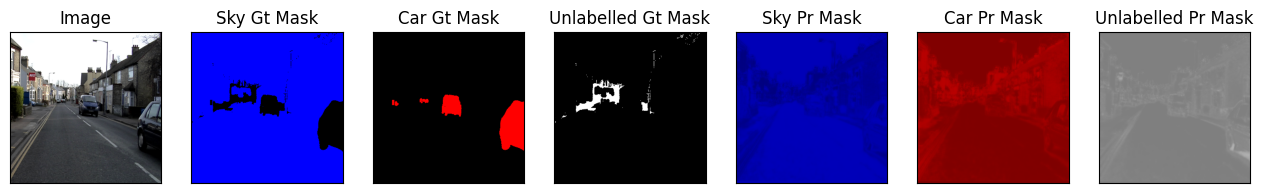

In [65]:
model_name = "cab2"
colors = {
    'sky': (0, 0, 255),         # Blue for 'sky'
    'building': (128, 128, 128), # Gray for 'building'
    'pole': (192, 192, 192),    # Light gray for 'pole'
    'road': (128, 64, 128),     # Purple-gray for 'road'
    'pavement': (244, 35, 232), # Pink for 'pavement'
    'tree': (0, 128, 0),        # Green for 'tree'
    'signsymbol': (220, 220, 0), # Yellow for 'signsymbol'
    'fence': (64, 128, 128),    # Teal for 'fence'
    'car': (255, 0, 0),         # Red for 'car'
    'pedestrian': (220, 20, 60), # Crimson for 'pedestrian'
    'bicyclist': (255, 255, 0),  # Bright yellow for 'bicyclist'
    'unlabelled': (255, 255, 255)     # White for 'unlabelled'
}

classes_visualise = ['sky', 'car', 'unlabelled']
classes_predict = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']

model_path = log_dir_train + '/best_model.pth'
test_model(model_path, model_name, None, x_test_dir, y_test_dir, classes_visualise, classes_visualise, colors, device)